## Load libraries

Kernel dies if I execute the following:

import os
import sys
hashseed = os.getenv('PYTHONHASHSEED')
if not hashseed:
    os.environ['PYTHONHASHSEED'] = '0'
    os.execv(sys.executable, [sys.executable] + sys.argv)

In [1]:
import os
import sys

import pandas as pd
import scanpy as sc
import anndata as ad
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.sparse as sps

# to be able to import from tools dir
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

# os.environ['R_HOME'] = "/Library/Frameworks/R.framework/Resources"
# import pertpy as pt
    
import tools.util_probe as up
import tools.util as ut
import tools.NB_est as nb
import tools.countsplit as cs
import tools.scDEED as scd
import tools.clustering_opt as co

import warnings
warnings.filterwarnings("ignore")

In [2]:
import importlib

## Preprocessing
### Read data

In [3]:
data_path = "../../data/MOBA_scRNAseq/outs_S2"
data_all = sc.read_10x_h5(data_path + "/filtered_feature_bc_matrix.h5")
data_all

AnnData object with n_obs × n_vars = 1326 × 21982
    var: 'gene_ids', 'feature_types', 'genome'

Pseudomonas strain, all genes belong to this genome, as we're only looking at one strain:

In [4]:
data_all.var["genome"].value_counts()

genome
PAO1    21982
Name: count, dtype: int64

Number of unique genes in strain:

### Aggregate probes through max-pooling

Bedingt durch Methode bekommen wir mehr Spalten... also beziehen sich mehrere Spalten auf ein Gen.
Paper dazu siehe Slack, geht darum wie UMI reads generiert werden. Es gibt versch. Probe-Sets, die das Genom

-> Benennung: 

In [5]:
data_maxpool = up.prep_probe_BacSC_data(data_all, agg_fn=np.max)

Aggregating feature 100/5572
Aggregating feature 200/5572
Aggregating feature 300/5572
Aggregating feature 400/5572
Aggregating feature 500/5572
Aggregating feature 600/5572
Aggregating feature 700/5572
Aggregating feature 800/5572
Aggregating feature 900/5572
Aggregating feature 1000/5572
Aggregating feature 1100/5572
Aggregating feature 1200/5572
Aggregating feature 1300/5572
Aggregating feature 1400/5572
Aggregating feature 1500/5572
Aggregating feature 1600/5572
Aggregating feature 1700/5572
Aggregating feature 1800/5572
Aggregating feature 1900/5572
Aggregating feature 2000/5572
Aggregating feature 2100/5572
Aggregating feature 2200/5572
Aggregating feature 2300/5572
Aggregating feature 2400/5572
Aggregating feature 2500/5572
Aggregating feature 2600/5572
Aggregating feature 2700/5572
Aggregating feature 2800/5572
Aggregating feature 2900/5572
Aggregating feature 3000/5572
Aggregating feature 3100/5572
Aggregating feature 3200/5572
Aggregating feature 3300/5572
Aggregating feature

In [6]:
data_maxpool

AnnData object with n_obs × n_vars = 1326 × 5572
    var: 'feature_types', 'genome'

In [7]:
sc.pp.calculate_qc_metrics(data_maxpool, var_type="genes", percent_top=None, log1p=True, inplace=True)
data_maxpool

AnnData object with n_obs × n_vars = 1326 × 5572
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts'
    var: 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

In [8]:
print(f"Zero inflation of probe-wise data: {((np.prod(data_all.X.shape) - data_all.X.getnnz()) / np.prod(data_all.X.shape)).round(3)}")
print(f"Zero inflation of aggregated data: {((np.prod(data_maxpool.X.shape) - data_maxpool.X.getnnz()) / np.prod(data_maxpool.X.shape)).round(3)}")


Zero inflation of probe-wise data: 0.947
Zero inflation of aggregated data: 0.856


## Attach transcription units

tu = pd.read_csv("../../data/MOBA_scRNAseq/PAO1 gene ID and TU.csv")
tu

data_maxpool.var = pd.merge(data_maxpool.var, tu, left_index=True, right_on="PAO1_ID")
data_maxpool.var.index = data_maxpool.var["PAO1_ID"]
data_maxpool.var

## Filter cells

Filter based on median absolute standard deviation:

- log1p_total_counts: count depth (number of counts per barcode)
- log1p_n_genes_by_counts: number of detected genes by barcode

Filter genes based on:
- min_cells = 2: at least gene is expressed in 2 cells

Further, filter cells based on:
- min_genes: at least 2 genes have to be expressed

In [9]:
importlib.reload(ut)
data_gene = ut.filter_outliers(data_maxpool, nmads=5, min_cells=2)
print(data_maxpool.obs.outlier.value_counts())
print(f"Total number of cells: {data_maxpool.n_obs}")
print(f"Number of cells after filtering: {data_gene.n_obs}")
data_gene

outlier
False    1255
True       71
Name: count, dtype: int64
Total number of cells: 1326
Number of cells after filtering: 1255


AnnData object with n_obs × n_vars = 1255 × 5540
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'outlier', 'n_genes'
    var: 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'

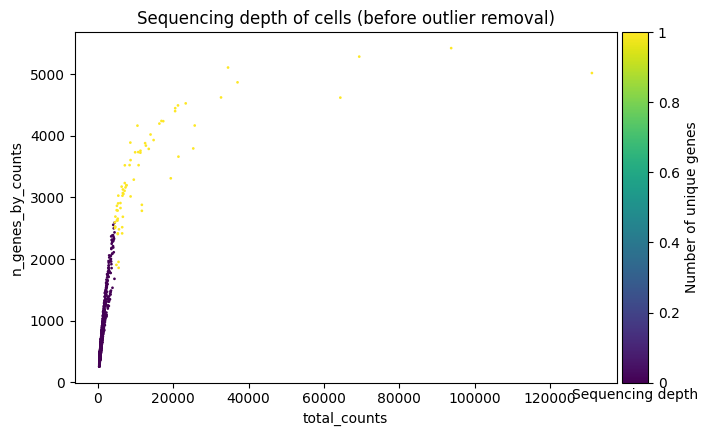

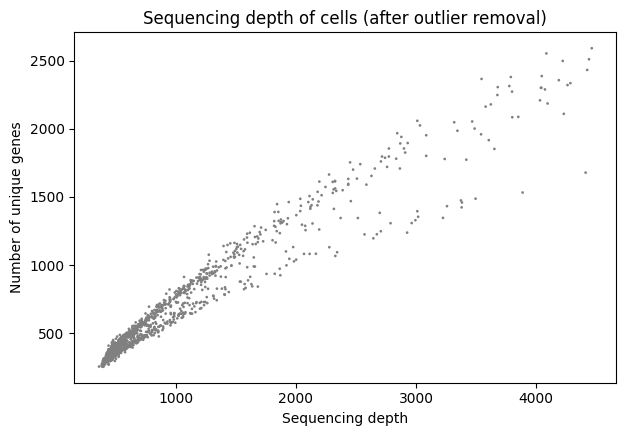

In [10]:
sc.pl.scatter(data_maxpool, x='total_counts', y='n_genes_by_counts', color="outlier", show=False, size=15, color_map="viridis", title="Sequencing depth of cells (before outlier removal)")
plt.xlabel("Sequencing depth")
plt.ylabel("Number of unique genes")
plt.show()

sc.pl.scatter(data_gene, x='total_counts', y='n_genes_by_counts', show=False, size=15)
plt.title("Sequencing depth of cells (after outlier removal)")
plt.xlabel("Sequencing depth")
plt.ylabel("Number of unique genes")
plt.show()

## Variance stabilization

Plotting the mean-variance ratio of genes, we see that the data is clearly overdispersed. Therefore, we will use negative binomial count splitting

In [11]:
data_gene.layers["counts"] = data_gene.X.copy()

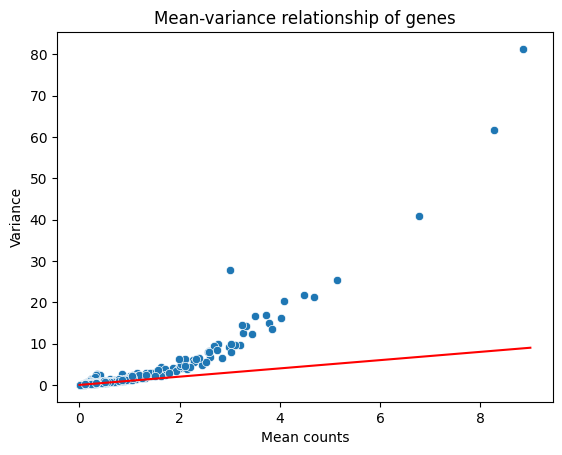

In [12]:
data_gene.var["var_counts"] = np.asarray(np.var(data_gene.X.toarray(), axis=0)).squeeze()
data_gene.var["mean_counts"] = np.asarray(np.mean(data_gene.X.toarray(), axis=0)).squeeze()
sns.scatterplot(data=data_gene.var, x="mean_counts", y="var_counts")
plt.plot([0, np.ceil(np.max(data_gene.var["mean_counts"]))], [0, np.ceil(np.max(data_gene.var["mean_counts"]))], color="red")
plt.title("Mean-variance relationship of genes")
plt.xlabel("Mean counts")
plt.ylabel("Variance")
plt.show()

## Estimate negative binomial parameters for each gene

In [13]:
nb.estimate_overdisp_nb(data_gene, layer="counts", flavor="BFGS")
data_gene.var["nb_overdisp_cutoff_bfgs"] = data_gene.var["nb_overdisp_cutoff"]
data_gene.var["nb_overdisp_bfgs"] = data_gene.var["nb_overdisp"]


Fitting feature 100/5540
Fitting feature 200/5540
Fitting feature 300/5540
Fitting feature 400/5540
Fitting feature 500/5540
Fitting feature 600/5540
Fitting feature 700/5540
Fitting feature 800/5540
Fitting feature 900/5540
Fitting feature 1000/5540
Fitting feature 1100/5540
Fitting feature 1200/5540
Fitting feature 1300/5540
Fitting feature 1400/5540
Fitting feature 1500/5540
Fitting feature 1600/5540
Fitting feature 1700/5540
Fitting feature 1800/5540
Fitting feature 1900/5540
Fitting feature 2000/5540
Fitting feature 2100/5540
Fitting feature 2200/5540
Fitting feature 2300/5540
Fitting feature 2400/5540
Fitting feature 2500/5540
Fitting feature 2600/5540
Fitting feature 2700/5540
Fitting feature 2800/5540
Fitting feature 2900/5540
Fitting feature 3000/5540
Fitting feature 3100/5540
Fitting feature 3200/5540
Fitting feature 3300/5540
Fitting feature 3400/5540
Fitting feature 3500/5540
Fitting feature 3600/5540
Fitting feature 3700/5540
Fitting feature 3800/5540
Fitting feature 3900/

In [14]:
data_gene

AnnData object with n_obs × n_vars = 1255 × 5540
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'outlier', 'n_genes'
    var: 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'var_counts', 'nb_mean', 'nb_overdisp', 'nb_overdisp_cutoff', 'nb_overdisp_cutoff_bfgs', 'nb_overdisp_bfgs'
    layers: 'counts'

<Axes: xlabel='nb_mean', ylabel='Count'>

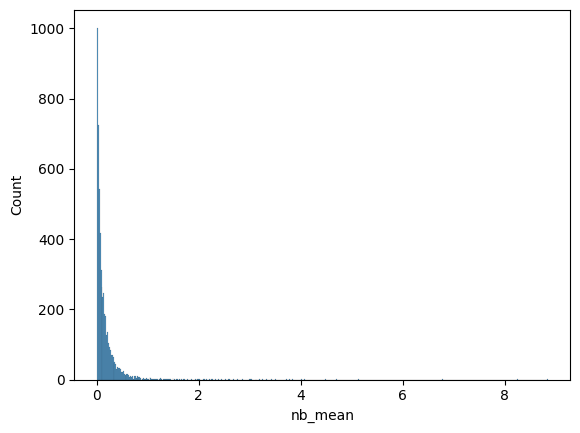

In [15]:
sns.histplot(data_gene.var["nb_mean"])

<Axes: xlabel='nb_overdisp', ylabel='Count'>

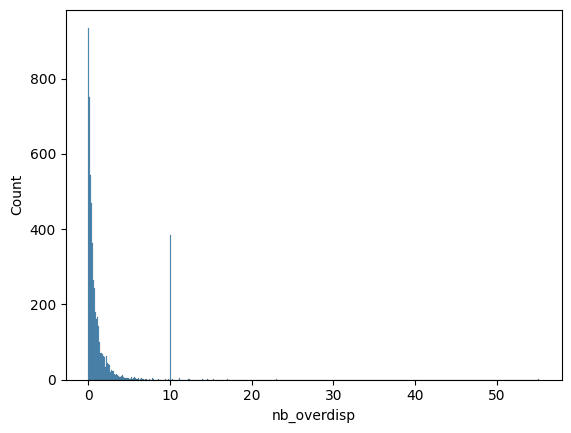

In [16]:
sns.histplot(data_gene.var["nb_overdisp"])

In [17]:
importlib.reload(nb)
nb.estimate_overdisp_nb(data_gene, layer="counts", flavor="sctransform")

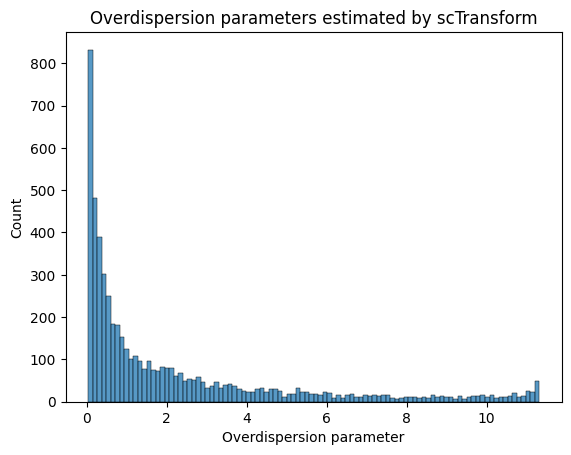

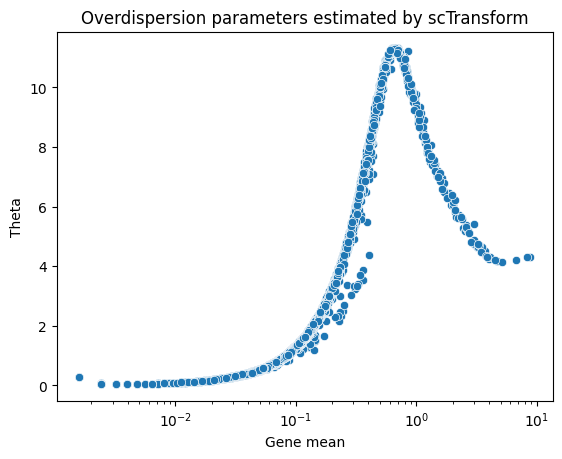

In [18]:
sns.histplot(data=data_gene.var, x="nb_overdisp_cutoff", bins=100)
plt.title("Overdispersion parameters estimated by scTransform")
plt.xlabel("Overdispersion parameter")
plt.show()

g = sns.scatterplot(data=data_gene.var, y="nb_overdisp_cutoff", x="mean_counts")
g.set(xscale="log")
plt.title("Overdispersion parameters estimated by scTransform")
plt.xlabel("Gene mean")
plt.ylabel("Theta")
plt.show()

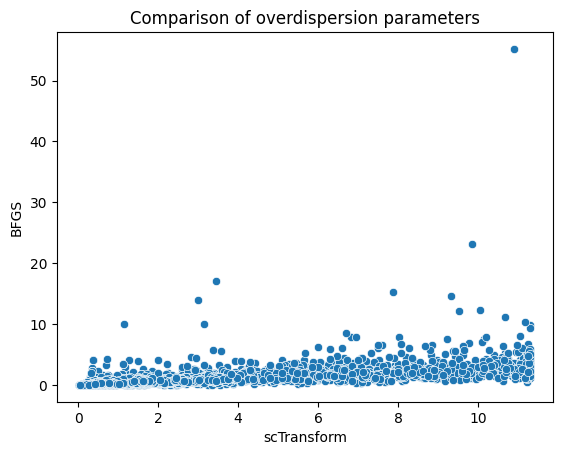

Correlation: [[1.         0.62726339]
 [0.62726339 1.        ]]


In [19]:
g = sns.scatterplot(data=data_gene.var, y="nb_overdisp_cutoff_bfgs", x="nb_overdisp_cutoff")
plt.title("Comparison of overdispersion parameters")
plt.xlabel("scTransform")
plt.ylabel("BFGS")
plt.show()

print(f"Correlation: {np.corrcoef(data_gene.var['nb_overdisp_cutoff_bfgs'], data_gene.var['nb_overdisp_cutoff'])}")

In [20]:
data_gene.X = data_gene.layers["counts"].copy()

In [21]:
data_gene

AnnData object with n_obs × n_vars = 1255 × 5540
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'outlier', 'n_genes'
    var: 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'var_counts', 'nb_mean', 'nb_overdisp', 'nb_overdisp_cutoff', 'nb_overdisp_cutoff_bfgs', 'nb_overdisp_bfgs'
    layers: 'counts'

## Normalization, VST, scaling and PCA

In [22]:
# Normalizes X, such that: each barcode has total count equal to median of total counts before normalization
sc.pp.normalize_total(data_gene, target_sum=None, layer=None)

# Only normalization
data_gene.layers["normalized_counts"] = data_gene.X.copy()

# Variance Stabilization Transformation
data_gene.X = sps.csr_matrix(np.log(data_gene.X.toarray() + np.array(data_gene.var["nb_overdisp_cutoff"] / 4)))
data_gene.layers["vst_counts"] = data_gene.X.copy()

#min_vst_counts = data_gene.layers["vst_counts"].min()

# Scale data to unit variance and zero mean. Truncate values to 10
#sc.pp.scale(data_gene, max_value=10, zero_center=True)
# data_gene.X[np.isnan(data_gene.X)] = 0

# Apply full PCA
sc.tl.pca(data_gene, svd_solver='arpack')

In [23]:
min_vst_count = data_gene.layers["vst_counts"].min()
min_vst_count

-4.75445464352453

In [24]:
vst_counts_shifted = data_gene.layers["vst_counts"].copy().todense() + min_vst_count*-1.01
vst_counts_shifted.min()

0.04754454643524575

In [25]:
data_gene.layers["vst_counts_shifted"] = vst_counts_shifted

In [26]:
data_gene

AnnData object with n_obs × n_vars = 1255 × 5540
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'outlier', 'n_genes'
    var: 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'var_counts', 'nb_mean', 'nb_overdisp', 'nb_overdisp_cutoff', 'nb_overdisp_cutoff_bfgs', 'nb_overdisp_bfgs'
    uns: 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'counts', 'normalized_counts', 'vst_counts', 'vst_counts_shifted'

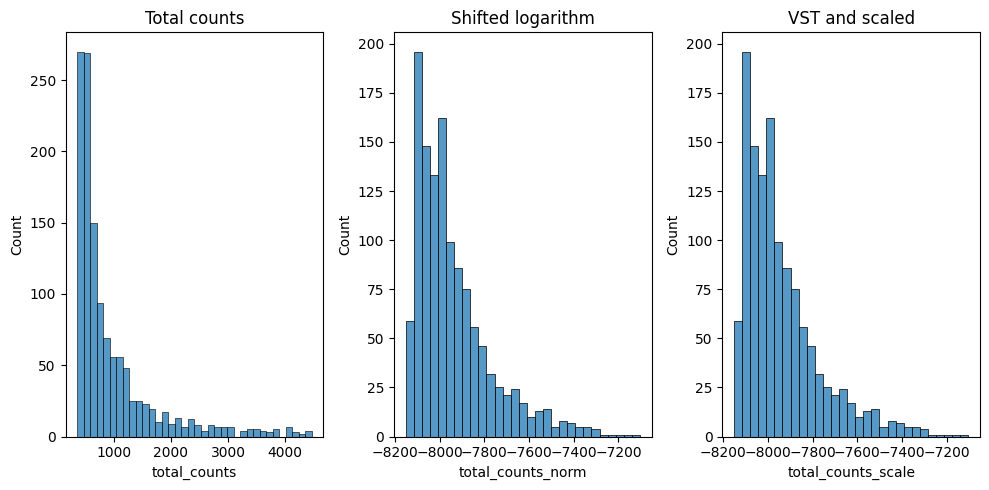

In [27]:
fig, axes = plt.subplots(1, 3, figsize=(10, 5))
p1 = sns.histplot(data_gene.obs, x="total_counts", kde=False, ax=axes[0], multiple="stack")
axes[0].set_title("Total counts")
data_gene.obs["total_counts_norm"] = data_gene.layers["vst_counts"].sum(1)
p2 = sns.histplot(data_gene.obs, x="total_counts_norm", kde=False, ax=axes[1], multiple="stack")
axes[1].set_title("Shifted logarithm")
data_gene.obs["total_counts_scale"] = data_gene.X.sum(1)
p2 = sns.histplot(data_gene.obs, x="total_counts_scale", kde=False, ax=axes[2], multiple="stack")
axes[2].set_title("VST and scaled")
plt.tight_layout()
plt.show()

## Count-splitting into train and test data

In [185]:
data_train, data_test = cs.countsplit_adata(data_gene, data_dist="NB", beta_key="nb_overdisp_cutoff", layer="counts", min_genes=1, max_counts=1e9, seed=1234)
print(data_train)

AnnData object with n_obs × n_vars = 1255 × 5423
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'outlier', 'n_genes', 'total_counts_norm', 'total_counts_scale', 'leiden_opt', 'embedding_reliability', 'reliability_score', 'null_reliability_score', 'n_counts', 'n_PCs_by_counts', 'log1p_n_PCs_by_counts'
    var: 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'var_counts', 'nb_mean', 'nb_overdisp', 'nb_overdisp_cutoff', 'nb_overdisp_cutoff_bfgs', 'nb_overdisp_bfgs'
    layers: 'counts'


Transformation of train and test data

In [186]:
# Normalizes X, such that: each barcode has total count equal to median of total counts before normalization
sc.pp.normalize_total(data_train, target_sum=None, layer=None)

# Only normalization
data_train.layers["normalized_counts"] = data_train.X.copy()

# Variance Stabilization Transformation
data_train.X = sps.csr_matrix(np.log(data_train.X.toarray() + np.array(data_train.var["nb_overdisp_cutoff"] / 4)))
data_train.layers["vst_counts"] = data_train.X.copy()
data_train.layers["vst_counts_shifted"] = data_train.layers["vst_counts"].copy().todense() + data_train.layers["vst_counts"].min() * -1.01

# test data
sc.pp.normalize_total(data_test, target_sum=None, layer=None)
data_test.layers["normalized_counts"] = data_test.X.copy()
data_test.X = sps.csr_matrix(np.log(data_test.X.toarray() + np.array(data_test.var["nb_overdisp_cutoff"] / 4)))
data_test.layers["vst_counts"] = data_test.X.copy()
data_test.layers["vst_counts_shifted"] = data_test.layers["vst_counts"].copy().todense() + data_test.layers["vst_counts"].min() * -1.01

In [187]:
from tools import NMD as nmd

In [188]:
importlib.reload(nmd)

<module 'tools.NMD' from '/Users/stffn/projects/thesis_dev/BacSC/tools/NMD.py'>

In [189]:
data_layer = "normalized_counts"

## Find latent dim: accelerated momentum

In [202]:
importlib.reload(cs)

<module 'tools.countsplit' from '/Users/stffn/projects/thesis_dev/BacSC/tools/countsplit.py'>

In [206]:
#latent_dims_2_check_anmd = [15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1]
latent_dims_2_check_anmd = [10, 9, 8, 7, 6, 5, 4, 3, 2]
betas_2_check = [0.8, 0.9, 0.95, 0.99]

In [195]:
data_train.layers["vst_counts_shifted"].shape

(1255, 5423)

In [196]:
data_layer = "normalized_counts"

In [207]:
select_cs_results = cs.select_nmd_t_latentdim_countsplit(data_train, data_test, potential_ks=latent_dims_2_check_anmd, do_warmstart=False, layer=data_layer, potential_betas=betas_2_check)

################## LATENT DIM 6
################## BETA 0.5
################## BETA 0.8
################## BETA 0.95
################## LATENT DIM 5
################## BETA 0.5
################## BETA 0.8
################## BETA 0.95
################## LATENT DIM 4
################## BETA 0.5
################## BETA 0.8
################## BETA 0.95
################## LATENT DIM 3
################## BETA 0.5
################## BETA 0.8
################## BETA 0.95
################## LATENT DIM 2
################## BETA 0.5
################## BETA 0.8
################## BETA 0.95


In [208]:
select_cs_results

array([[543.3456088 , 543.69064212, 533.92195447],
       [540.03560238, 540.15126677, 530.77418239],
       [534.03773306, 533.37258185, 524.02635466],
       [531.20835467, 531.41851177, 516.21590457],
       [528.6015805 , 529.16705493, 515.89365891]])

In [249]:
pd.DataFrame(select_cs_results, columns=betas_2_check, index=latent_dims_2_check_anmd)

,0.50,0.80,0.95
6,543.345609,543.690642,533.921954
5,540.035602,540.151267,530.774182
4,534.037733,533.372582,524.026355
3,531.208355,531.418512,516.215905
2,528.601580,529.167055,515.893659


In [245]:
np.argmin(select_cs_results, axis=1)

array([2, 2, 2, 2, 2])

In [211]:
k_opt_anmd = 3
beta_opt = 0.95

k_errors_anmd, k_opt_anmd = cs.select_anmd_latentdim_countsplit(data_train, data_test, potential_ks=latent_dims_2_check_anmd, do_warmstart=False, layer=data_layer, beta=0.4)
print(f"Optimal latent dimension:{k_opt_anmd}")

k_errors_anmd, k_opt_anmd = cs.select_3b_latentdim_countsplit(data_train, data_test, potential_ks=latent_dims_2_check_anmd, do_warmstart=True, layer=data_layer, beta1=0.9)
print(f"Optimal latent dimension:{k_opt_anmd}")

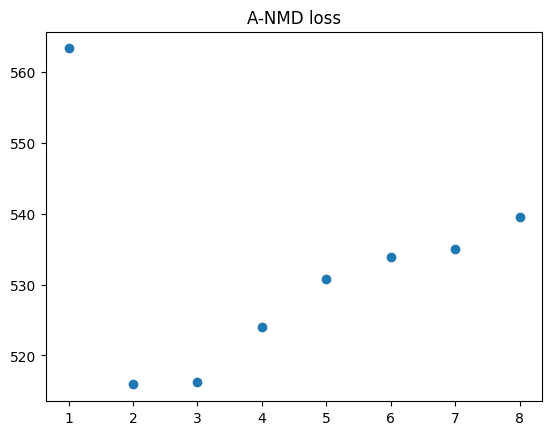

2 latent dimensions seem to be the optimum


In [50]:
plt.scatter(latent_dims_2_check_anmd, k_errors_anmd)
plt.title("A-NMD loss")
plt.show()

print(f"{k_opt_anmd} latent dimensions seem to be the optimum")

In [212]:
m, n = data_gene.X.shape
X_anmd = ut.convert_to_dense_counts(data_gene, layer=data_layer)
m, n = X_anmd.shape
W0, H0 = cs.nuclear_norm_init(X_anmd, m, n, k_opt_anmd)
Theta0 = W0 @ H0

In [213]:
from tools import NMD as nmd

In [214]:
importlib.reload(nmd)

<module 'tools.NMD' from '/Users/stffn/projects/thesis_dev/BacSC/tools/NMD.py'>

In [215]:
Theta_3b, W0_3b, H0_3b,  loss_anmd, iters_anmd, times_anmd = nmd.nmd_t(X_anmd, r=k_opt_anmd, W0=W0, H0=H0, beta1=beta_opt)

Running NMD-T, evolution of [iteration number : relative error in %] - time per iteration
[0 : 73.636229] - 0.257531 secs
[1 : 73.172271] - 0.241590 secs
[2 : 73.112225] - 0.238834 secs
[3 : 73.732892] - 0.252275 secs
[4 : 74.342318] - 0.244364 secs
[5 : 74.441591] - 0.248429 secs
[6 : 74.586672] - 0.251119 secs
[7 : 74.220888] - 0.248387 secs
[8 : 74.012461] - 0.236712 secs
[9 : 73.754435] - 0.234913 secs
[10 : 73.590797] - 0.234990 secs
[11 : 73.294593] - 0.236719 secs
[12 : 73.165919] - 0.237571 secs
[13 : 73.227239] - 0.238062 secs
[14 : 73.048944] - 0.236030 secs
[15 : 73.020056] - 0.235228 secs
[16 : 72.970226] - 0.238476 secs
[17 : 72.856716] - 0.339991 secs
[18 : 72.876101] - 0.246602 secs
[19 : 72.865705] - 0.229262 secs
[20 : 72.791730] - 0.233235 secs
[21 : 72.776103] - 0.233512 secs
[22 : 72.771205] - 0.231469 secs
[23 : 72.716213] - 0.236266 secs
[24 : 72.705295] - 0.232351 secs
[25 : 72.713646] - 0.229934 secs
[26 : 72.684967] - 0.234369 secs
[27 : 72.684538] - 0.232983 s

Theta_3b,  loss_anmd, iters_anmd, times_anmd = nmd.a_nmd(X_anmd, r=k_opt_anmd, Theta0=Theta0, tol_over_10iters=1.0e-4)

In [60]:
def two_part_factor(matrix):
    """Factor matrix into two rectangular matrices with inner dimension matching its rank.

    Args:
        matrix: Low-rank matrix to factor into two

    Returns:
        Two matrices whose product is the original matrix.
    """
    rank = np.linalg.matrix_rank(matrix)
    (svd_U, svd_S, svd_Vt) = np.linalg.svd(matrix)
    inner_a = np.zeros((matrix.shape[0], rank))
    np.fill_diagonal(inner_a, svd_S)
    part_A = svd_U @ inner_a
    part_B = np.pad(np.eye(rank), ((0, 0), (0, matrix.shape[1] - rank))) @ svd_Vt
    return (part_A, part_B)

In [61]:
W_3b, H_3b = two_part_factor(Theta_3b)

Theta_3b, W_3b, H_3b,  loss_anmd, iters_anmd, times_anmd = nmd.nmd_3b(X_anmd, r=k_opt_anmd, W0=W0, H0=H0, tol_over_10iters=1.0e-4, beta1=0.9)

W => embeddings

In [216]:
data_gene.obsm["X_3b"] = W0_3b.copy()
#data_gene.obsm["X_3b"] = Theta_3b.copy()

In [217]:
data_gene

AnnData object with n_obs × n_vars = 1255 × 5540
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'outlier', 'n_genes', 'total_counts_norm', 'total_counts_scale', 'leiden_opt', 'embedding_reliability', 'reliability_score', 'null_reliability_score'
    var: 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'var_counts', 'nb_mean', 'nb_overdisp', 'nb_overdisp_cutoff', 'nb_overdisp_cutoff_bfgs', 'nb_overdisp_bfgs'
    uns: 'pca', 'neighbors', 'umap', 'leiden', 'leiden_opt_colors', 'rank_genes_groups', 'embedding_reliability_colors'
    obsm: 'X_pca', 'X_3b', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'normalized_counts', 'vst_counts', 'vst_counts_shifted'
    obsp: 'distances', 'connectivities'

In [218]:
importlib.reload(scd)

n_neighborss = [10, 15, 20, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100, 150, 200, 250]
#n_neighborss = [10, 20, 30, 40, 50, 60, 80, 100, 150, 200]
min_dists = [0.05, 0.1, 0.3, 0.5, 0.7]

scdeed_result, rel_scores, null_rel_scores, reliabilities, n_neighbors_opt, min_dist_opt = scd.scdeed_parameter_selection(
    data_gene, n_neighborss, min_dists, n_pcs=k_opt_anmd, rng_seed=5678, layer = "normalized_counts",
    embedding_method="UMAP", similarity_percent=0.5, save_path="S2_filtered_scdeed_nmd")

calculating (10, 0.05) - run 1/85
calculating (10, 0.1) - run 2/85
calculating (10, 0.3) - run 3/85
calculating (10, 0.5) - run 4/85
calculating (10, 0.7) - run 5/85
calculating (15, 0.05) - run 6/85
calculating (15, 0.1) - run 7/85
calculating (15, 0.3) - run 8/85
calculating (15, 0.5) - run 9/85
calculating (15, 0.7) - run 10/85
calculating (20, 0.05) - run 11/85
calculating (20, 0.1) - run 12/85
calculating (20, 0.3) - run 13/85
calculating (20, 0.5) - run 14/85
calculating (20, 0.7) - run 15/85
calculating (25, 0.05) - run 16/85
calculating (25, 0.1) - run 17/85
calculating (25, 0.3) - run 18/85
calculating (25, 0.5) - run 19/85
calculating (25, 0.7) - run 20/85
calculating (30, 0.05) - run 21/85
calculating (30, 0.1) - run 22/85
calculating (30, 0.3) - run 23/85
calculating (30, 0.5) - run 24/85
calculating (30, 0.7) - run 25/85
calculating (35, 0.05) - run 26/85
calculating (35, 0.1) - run 27/85
calculating (35, 0.3) - run 28/85
calculating (35, 0.5) - run 29/85
calculating (35, 

In [121]:
#n_neighbors_opt = 100
#n_neighbors_opt =35
#min_dist_opt = 0.5
#min_dist_opt = 0.3

Optimal number of neighbors: 250
Optimal min_dist: 0.1


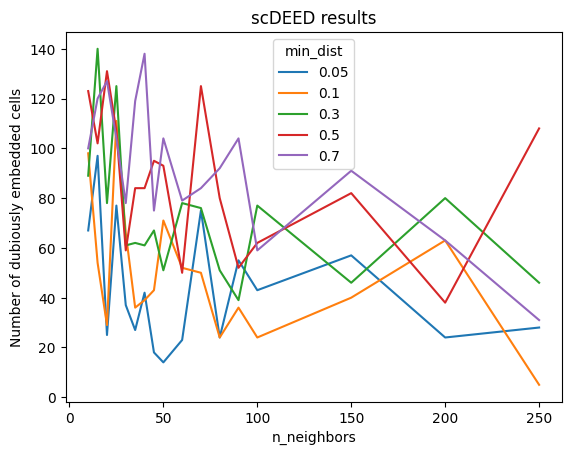

In [219]:
print(f"Optimal number of neighbors: {n_neighbors_opt}")
print(f"Optimal min_dist: {min_dist_opt}")

sns.lineplot(data=scdeed_result, x="n_neighbors", y="num_dubious", hue="min_dist", palette="tab10")
plt.title("scDEED results")
plt.ylabel("Number of dubiously embedded cells")
plt.show()

In [225]:
n_neighbors_opt = 250
min_dist_opt = 0.1

In [226]:
sc.pp.neighbors(data_gene, n_neighbors=n_neighbors_opt, n_pcs=k_opt_anmd, use_rep="X_3b")
sc.tl.umap(data_gene, neighbors_key="neighbors", min_dist=min_dist_opt, spread=1)


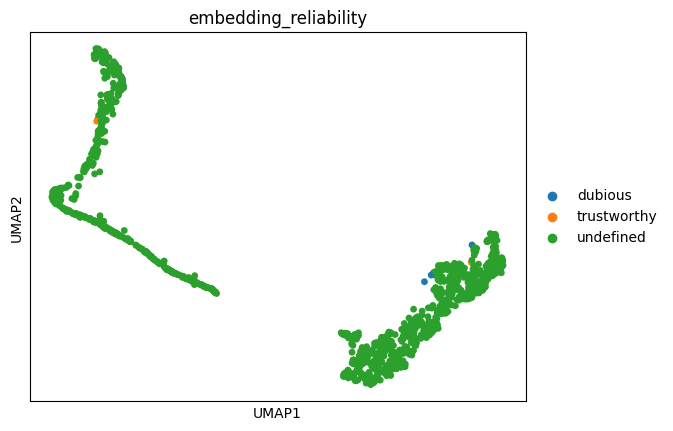

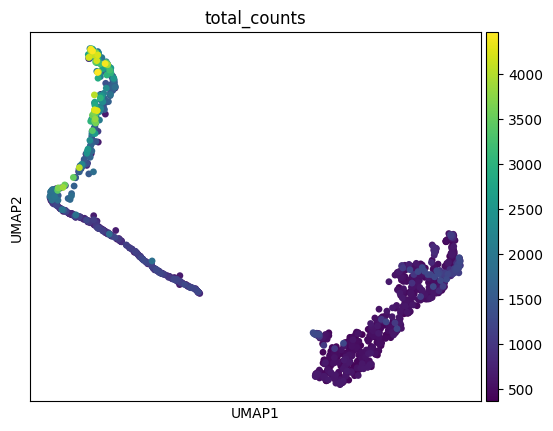

In [227]:
sc.pl.umap(data_gene, color="embedding_reliability", alpha=1)
plt.show()

sc.pl.umap(data_gene, color="total_counts", alpha=1, cmap="viridis")
plt.show()

In [228]:
X_anmd_train = ut.convert_to_dense_counts(data_train, layer=data_layer)
m, n = X_anmd_train.shape
W0_train, H0_train = cs.nuclear_norm_init(X_anmd_train, m, n, k_opt_anmd)

In [229]:
X_anmd_test = ut.convert_to_dense_counts(data_test, layer=data_layer)
m, n = X_anmd_test.shape
W0_test, H0_test = cs.nuclear_norm_init(X_anmd_test, m, n, k_opt_anmd)

In [230]:
_, W_train_3b, H_train_3b,  _, _, _ = nmd.nmd_t(X_anmd_train, r=k_opt_anmd, W0=W0_train, H0=H0_train, beta1=beta_opt)

Running NMD-T, evolution of [iteration number : relative error in %] - time per iteration
[0 : 84.932269] - 0.249115 secs
[1 : 84.844970] - 0.256138 secs
[2 : 84.898881] - 0.349082 secs
[3 : 85.347270] - 0.341535 secs
[4 : 85.469759] - 0.229557 secs
[5 : 85.840921] - 0.234474 secs
[6 : 86.343876] - 0.233360 secs
[7 : 86.425234] - 0.232195 secs
[8 : 86.843949] - 0.230453 secs
[9 : 87.250840] - 0.235715 secs
[10 : 87.356937] - 0.231620 secs
[11 : 87.479496] - 0.233135 secs
[12 : 87.556711] - 0.242196 secs
[13 : 87.515234] - 0.231508 secs
[14 : 87.413939] - 0.232629 secs
[15 : 87.277395] - 0.229542 secs
[16 : 87.111912] - 0.232143 secs
[17 : 86.959123] - 0.231904 secs
[18 : 86.783529] - 0.236700 secs
[19 : 86.598444] - 0.238253 secs
[20 : 86.434108] - 0.232469 secs
[21 : 86.262424] - 0.233474 secs
[22 : 86.097283] - 0.231700 secs
[23 : 85.945923] - 0.237102 secs
[24 : 85.799395] - 0.236092 secs
[25 : 85.643738] - 0.232342 secs
[26 : 85.551189] - 0.309701 secs
[27 : 85.421512] - 0.267647 s

Theta_train_3b, _, _, _ = nmd.a_nmd(X_anmd_train, r=k_opt_anmd, tol_over_10iters=1e-4, Theta0=W0_train@H0_train)

Theta_train_3b, W_train_3b, H_train_3b, _, _, _ = nmd.nmd_3b(X_anmd_train, r=k_opt_anmd, W0=W0_train, H0=H0_train, beta1=0.9, tol_over_10iters=1e-4)

In [231]:
_, W_test_3b, H_test_3b,  _, _, _ = nmd.nmd_t(X_anmd_test, r=k_opt_anmd, W0=W0_test, H0=H0_test, beta1=beta_opt)

Running NMD-T, evolution of [iteration number : relative error in %] - time per iteration
[0 : 84.497337] - 0.285962 secs
[1 : 84.390053] - 0.255082 secs
[2 : 84.467407] - 0.245727 secs
[3 : 84.865870] - 0.255636 secs
[4 : 85.135010] - 0.227204 secs
[5 : 85.451482] - 0.234069 secs
[6 : 85.872181] - 0.234213 secs
[7 : 85.961700] - 0.232267 secs
[8 : 86.324041] - 0.233486 secs
[9 : 86.629416] - 0.234497 secs
[10 : 86.739018] - 0.232452 secs
[11 : 86.755266] - 0.232655 secs
[12 : 86.670820] - 0.349056 secs
[13 : 86.573497] - 0.320893 secs
[14 : 86.366200] - 0.238730 secs
[15 : 86.183191] - 0.233174 secs
[16 : 85.995352] - 0.235142 secs
[17 : 85.847807] - 0.234507 secs
[18 : 85.696802] - 0.232389 secs
[19 : 85.583565] - 0.233783 secs
[20 : 85.449749] - 0.233012 secs
[21 : 85.341379] - 0.232869 secs
[22 : 85.246398] - 0.233312 secs
[23 : 85.127914] - 0.264353 secs
[24 : 85.039780] - 0.304277 secs
[25 : 84.912074] - 0.324161 secs
[26 : 84.816378] - 0.283694 secs
[27 : 84.743330] - 0.302828 s

Theta_test_3b, _, _, _ = nmd.a_nmd(X_anmd_test, r=k_opt_anmd, tol_over_10iters=1e-4, Theta0=W0_test@H0_test)

Theta_test_3b, W_test_3b, H_test_3b, _, _, _ = nmd.nmd_3b(X_anmd_test, r=k_opt_anmd, W0=W0_test, H0=H0_test, beta1=0.9, tol_over_10iters=1e-4)

W_train_3b, H_train_3b = two_part_factor(Theta_train_3b)
W_test_3b, H_test_3b = two_part_factor(Theta_test_3b)

In [232]:
data_train.obsm["X_3b"] = W_train_3b
data_test.obsm["X_3b"] = W_test_3b
#data_train.obsm["X_3b"] = Theta_train_3b
#data_test.obsm["X_3b"] = Theta_test_3b

2D embedding nochmal mit UMAP auf zwei Dimensionen mappen macht keinen Sinn.

In [233]:
sc.pp.neighbors(data_train, n_neighbors=n_neighbors_opt, n_pcs=k_opt_anmd, use_rep="X_3b")
sc.tl.umap(data_train, neighbors_key="neighbors", min_dist=min_dist_opt, spread=1)

sc.pp.neighbors(data_test, n_neighbors=n_neighbors_opt, n_pcs=k_opt_anmd, use_rep="X_3b")
sc.tl.umap(data_test, neighbors_key="neighbors", min_dist=min_dist_opt, spread=1)


theta_opt, mirror_opt, umap_2_opt, ssd = ut.find_opt_umap_rotation(data_train.obsm["X_umap"].copy(), data_test.obsm["X_umap"].copy())
data_test.obsm["X_umap_rot"] = umap_2_opt

Daten könnten nur durch total_counts repräsentiert werden - liegt daran, dass nicht normalisiert wurde!

--> NMD auf counts per million (CPM) oder andere normalisierte Form der Daten, ist aber auch etwas problematisch, da viel dazugedichtet wird

Abhandlung dazu: Comparison of transformations for scRNA seq data

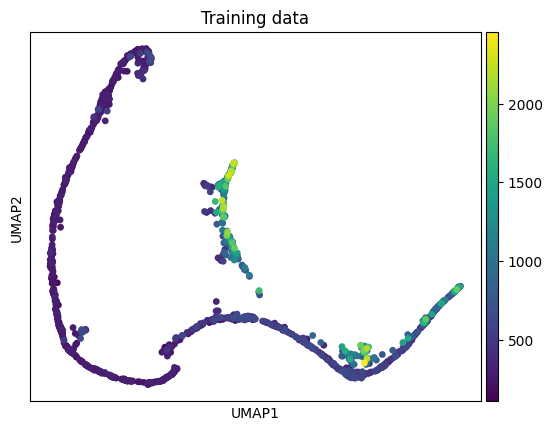

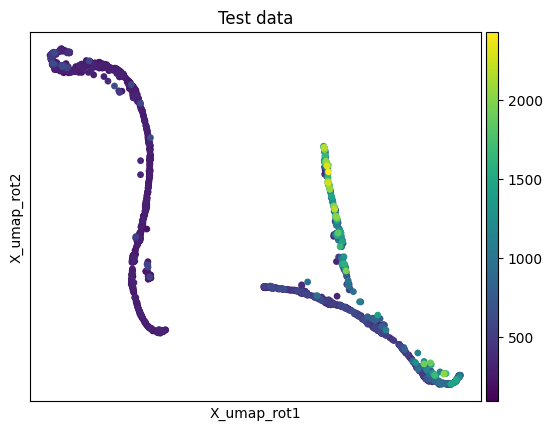

In [234]:
sc.pl.umap(data_train, color="total_counts", cmap="viridis", title="Training data")
plt.show()

sc.pl.embedding(data_test, basis="X_umap_rot", color="total_counts", cmap="viridis", title="Test data")
plt.show()

In [235]:
importlib.reload(co)
res_min = 0.01
res_max = 0.5
res_step = 0.02
resolutions = np.round(np.arange(res_min, res_max, res_step), 2)

co.cluster_train_test(data_train, data_test, resolutions, alg="leiden")

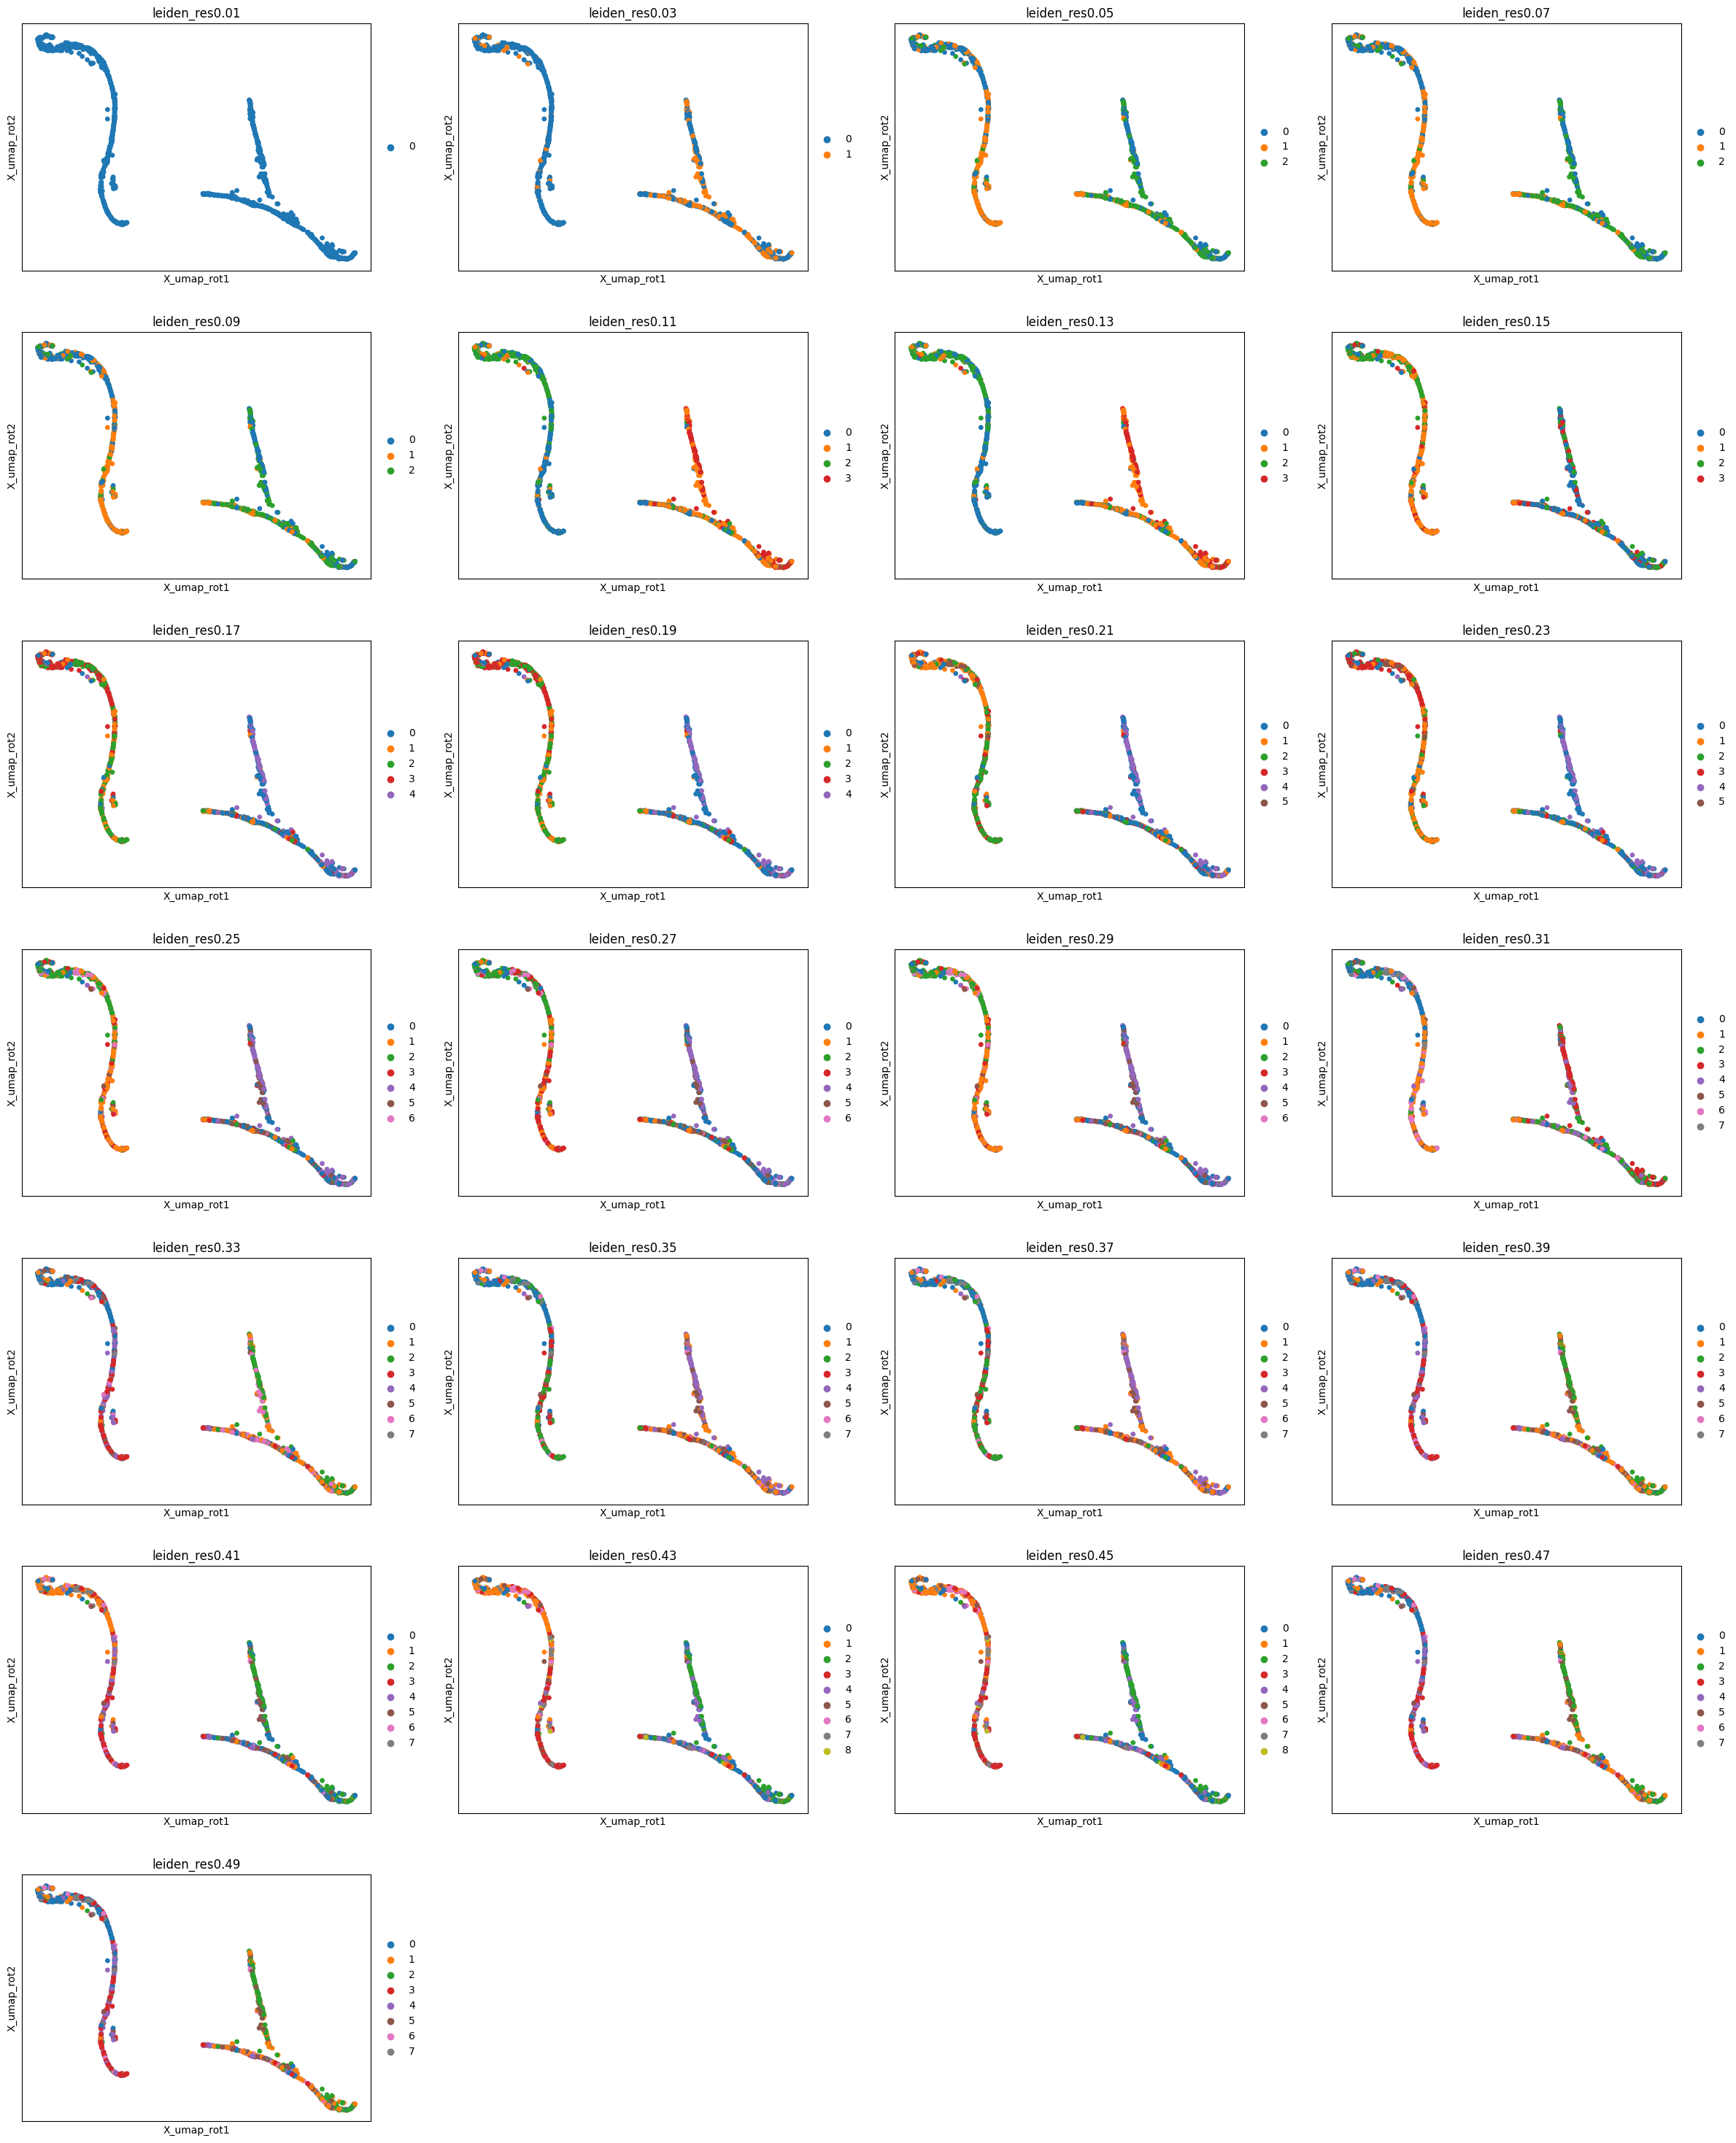

In [236]:
sc.pl.embedding(data_test, basis="X_umap_rot", color=[f"leiden_res{resolution}" for resolution in resolutions])
plt.show()

In [237]:
importlib.reload(co)
mod_df, mod_df_wide, res_opt = co.find_optimal_clustering_resolution(data_train, data_test, resolutions)

print(f"Optimal resolution {res_opt}")

resolution: 0.01 - clusters: 1 - Train: 0.49 - Test: 0.49 - Random: 0.49
resolution: 0.03 - clusters: 2 - Train: 0.462 - Test: 0.307 - Random: 0.274
resolution: 0.05 - clusters: 3 - Train: 0.418 - Test: 0.202 - Random: 0.151
resolution: 0.07 - clusters: 3 - Train: 0.411 - Test: 0.195 - Random: 0.144
resolution: 0.09 - clusters: 3 - Train: 0.404 - Test: 0.188 - Random: 0.138
resolution: 0.11 - clusters: 4 - Train: 0.365 - Test: 0.169 - Random: 0.106
resolution: 0.13 - clusters: 4 - Train: 0.36 - Test: 0.163 - Random: 0.1
resolution: 0.15 - clusters: 4 - Train: 0.34 - Test: 0.126 - Random: 0.087
resolution: 0.17 - clusters: 5 - Train: 0.298 - Test: 0.116 - Random: 0.071
resolution: 0.19 - clusters: 5 - Train: 0.293 - Test: 0.112 - Random: 0.067
resolution: 0.21 - clusters: 6 - Train: 0.272 - Test: 0.096 - Random: 0.054
resolution: 0.23 - clusters: 6 - Train: 0.265 - Test: 0.093 - Random: 0.051
resolution: 0.25 - clusters: 7 - Train: 0.23 - Test: 0.077 - Random: 0.038
resolution: 0.27 - c

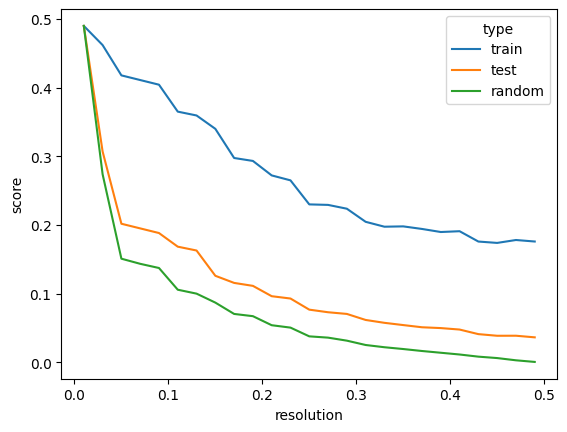

In [238]:
sns.lineplot(data=mod_df, x="resolution", y="score", hue="type")
plt.show()

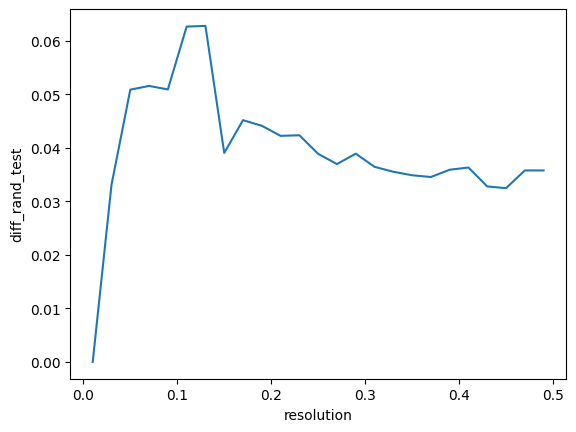

In [239]:
sns.lineplot(data=mod_df_wide, x="resolution", y="diff_rand_test")
plt.show()

In [240]:
sc.tl.leiden(data_gene, resolution=res_opt, key_added="leiden_opt")

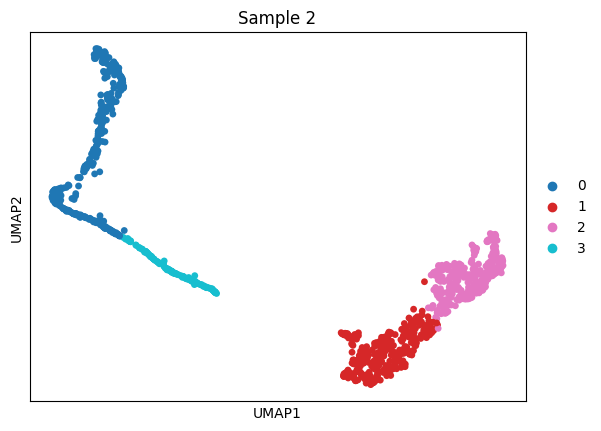

In [241]:
sc.pl.umap(data_gene, color="leiden_opt", palette="tab10", title="Sample 2")
plt.show()

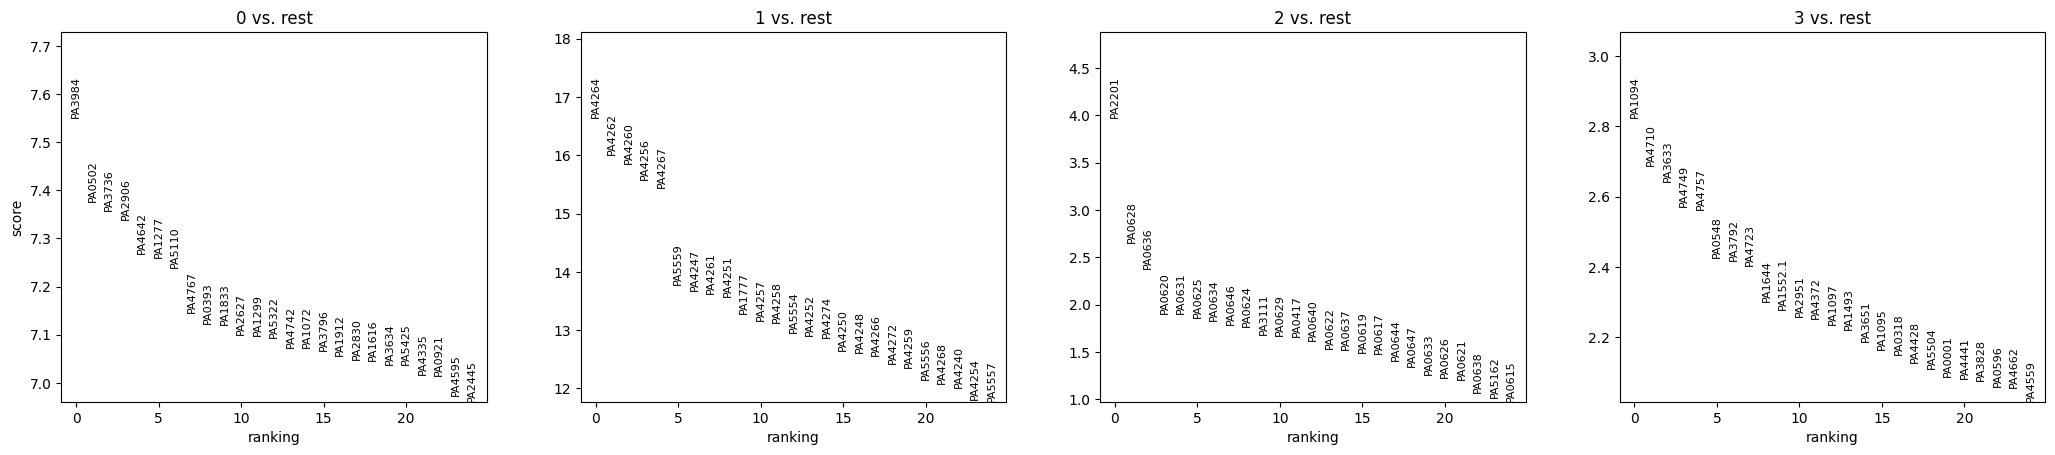

In [242]:
sc.tl.rank_genes_groups(data_gene, 'leiden_opt', method='wilcoxon')
sc.pl.rank_genes_groups(data_gene, n_genes=25, sharey=False)

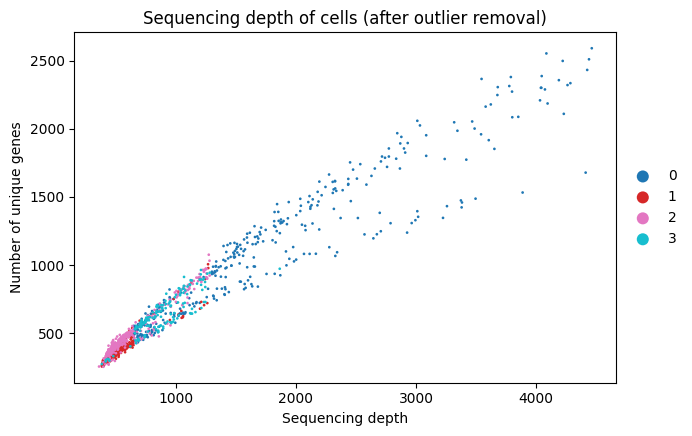

In [250]:
sc.pl.scatter(data_gene, x='total_counts', y='n_genes_by_counts', show=False, size=15, color="leiden_opt")
plt.title("Sequencing depth of cells (after outlier removal)")
plt.xlabel("Sequencing depth")
plt.ylabel("Number of unique genes")
plt.show()

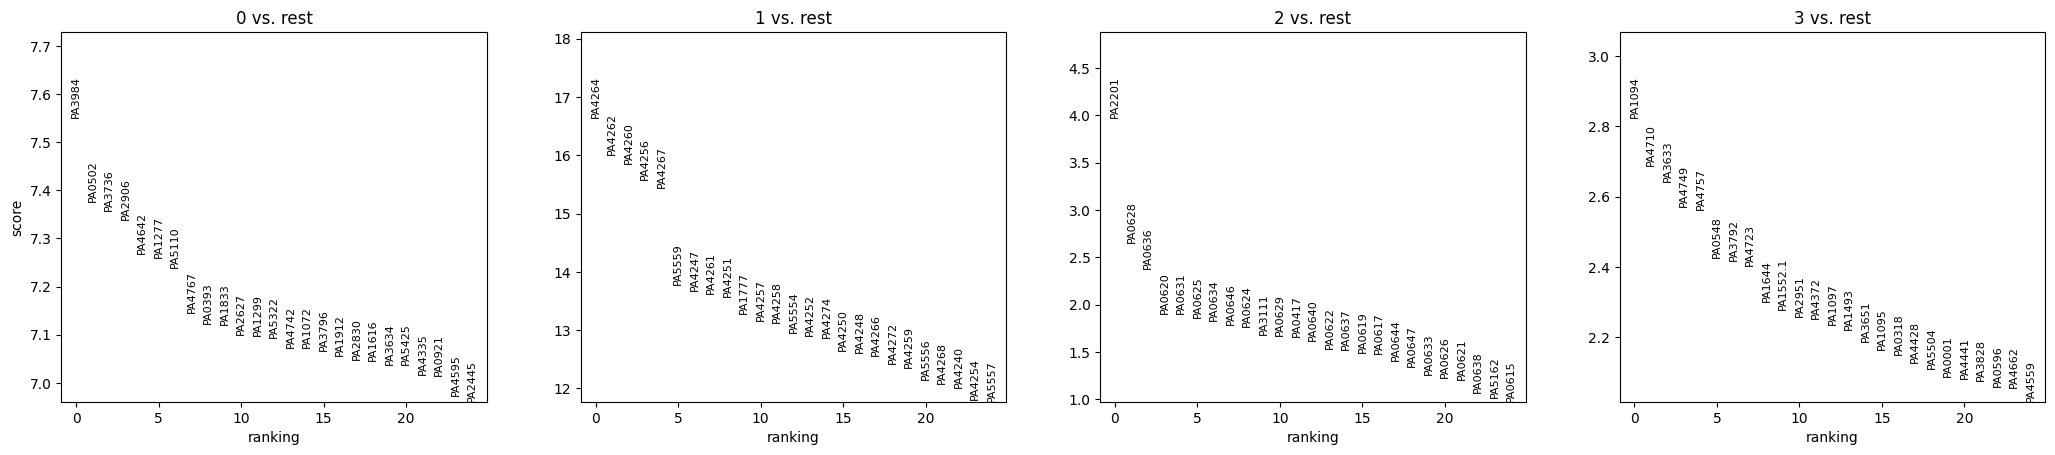

In [251]:
sc.tl.rank_genes_groups(data_gene, 'leiden_opt', method='wilcoxon')
sc.pl.rank_genes_groups(data_gene, n_genes=25, sharey=False)

In [252]:
top_genes_3 = [x[3] for x in data_gene.uns["rank_genes_groups"]["names"]]
print(top_genes_3[:25])

['PA1094', 'PA4710', 'PA3633', 'PA4749', 'PA4757', 'PA0548', 'PA3792', 'PA4723', 'PA1644', 'PA1552.1', 'PA2951', 'PA4372', 'PA1097', 'PA1493', 'PA3651', 'PA1095', 'PA0318', 'PA4428', 'PA5504', 'PA0001', 'PA4441', 'PA3828', 'PA0596', 'PA4662', 'PA4559']


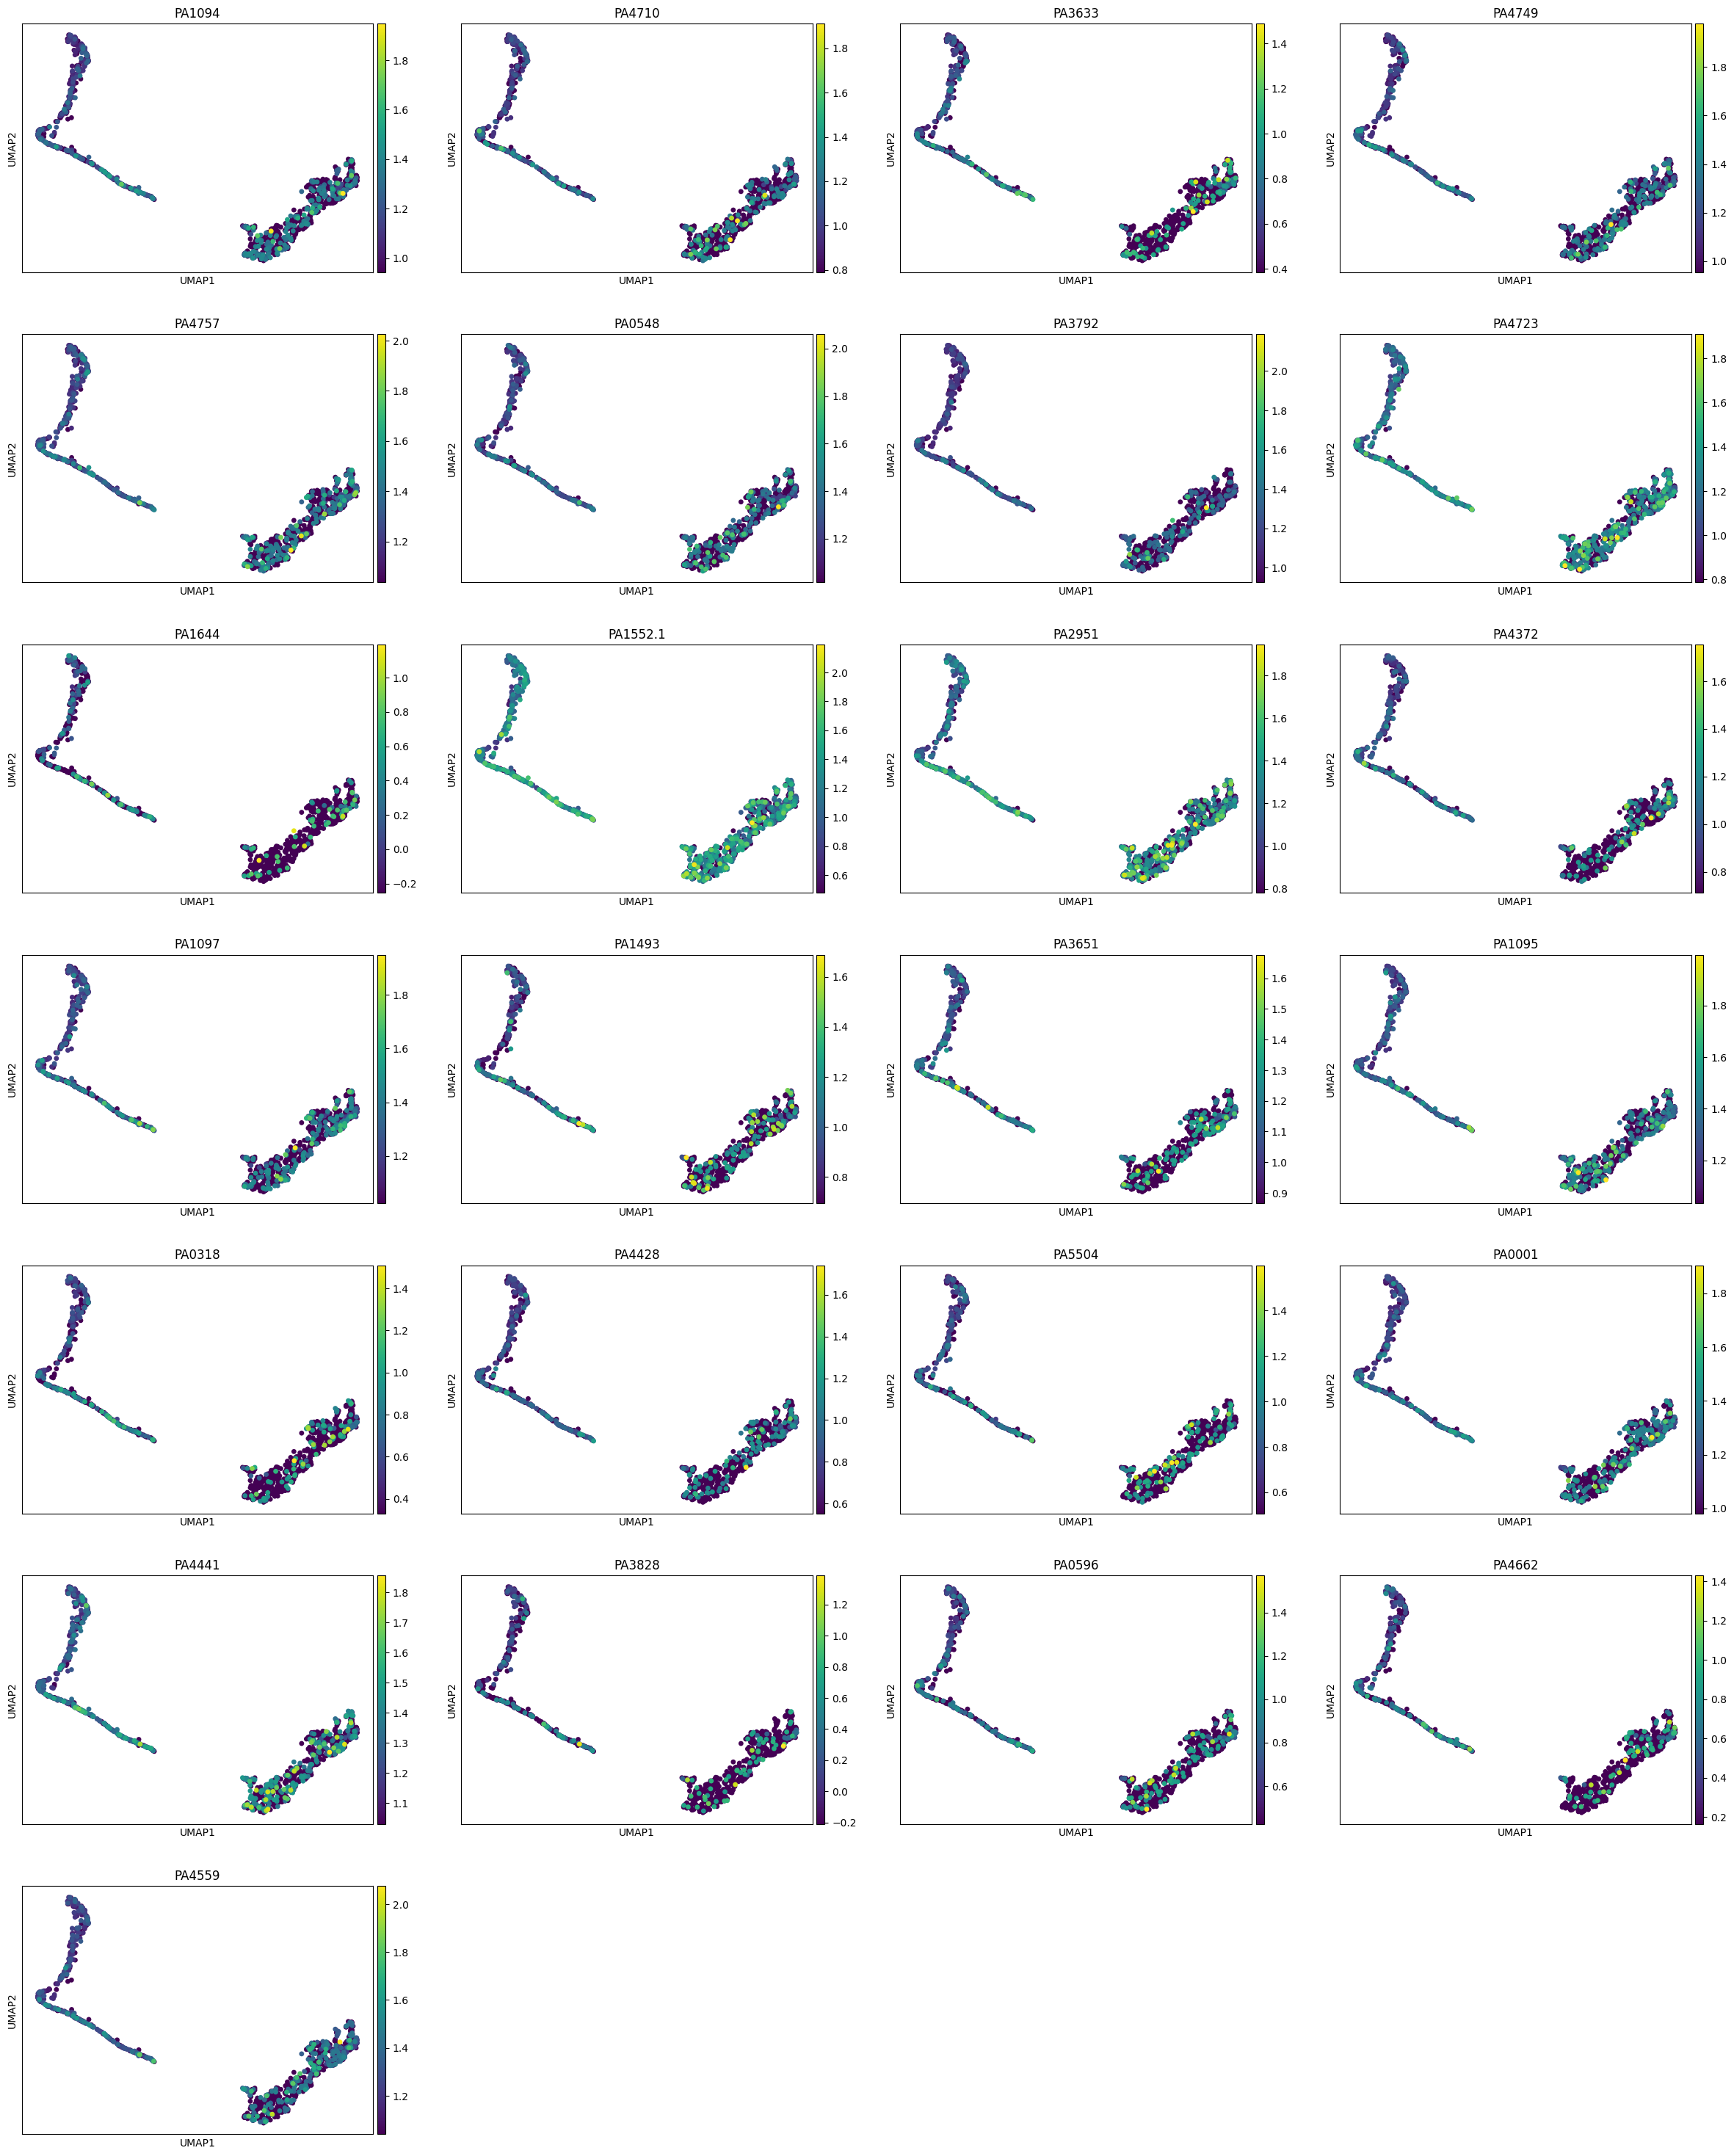

In [253]:
sc.pl.umap(data_gene, color=top_genes_3[:25], palette="tab20", cmap="viridis")

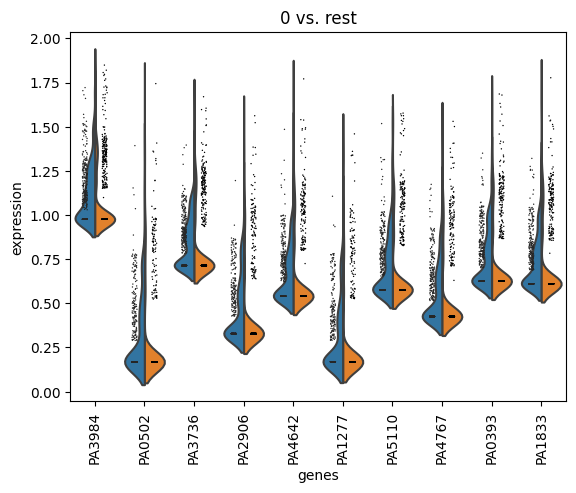

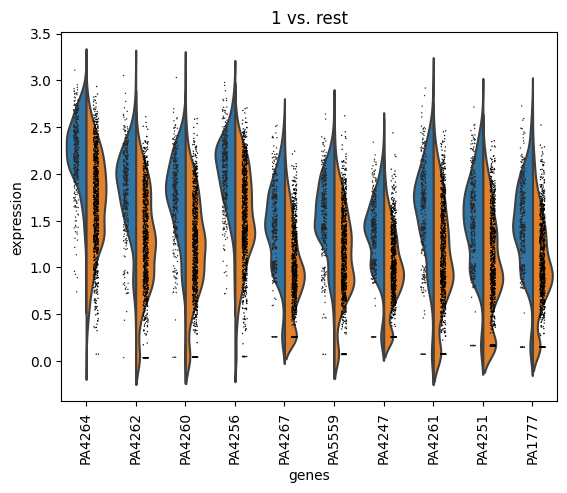

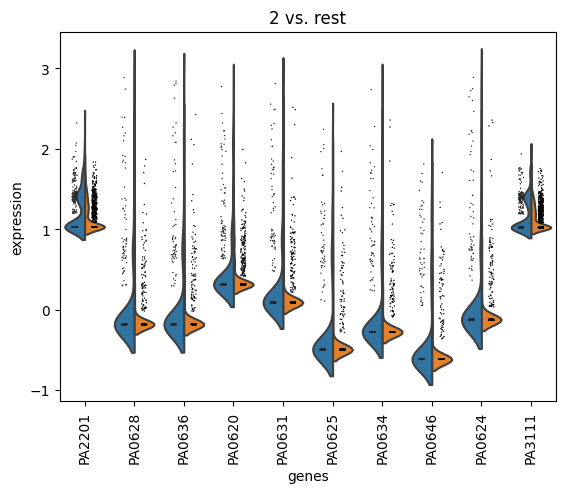

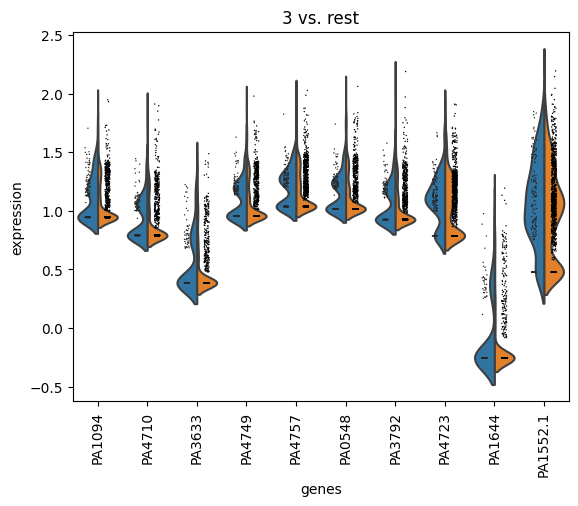

In [254]:
nclust = len(np.unique(data_gene.obs["leiden_opt"]))

for i in range(nclust):
    sc.pl.rank_genes_groups_violin(data_gene, groups=str(i), n_genes=10)